## DS Challenge
Accelerometer data from 22 people walking.  Explore and exploit the data for subject identification.

See README.md for more information

### Preprocessing & Feature Extraction
**Please see the `accelerometer_explore.ipynb` notebook for more information about preprocessing and feature extraction**

Features:
* Top 3 dominant frequencies in acceleartion magnitude over the sample (using FFT-based spectral density/periodogram)
* Magnitude of 3 dominant frequencies in spectral power
* Average acceleration for a user (required)
* Average time between observations for a user (required, but pointless, I already remove samples that have inconsistent sampling)

These features all have the benefit of being **rotation-invariant**.  If the phone/sensor is oriented differently in their pocket (relative to gravity), all these features will remain the same (as long as the sensitivity is consistent in each x,y,z).

I had considered adding x,y,z-specific features and rotating them so in 3D so that the average acceleration points towards -z and some other transormations to make it invariant to rotations around z-axis.  This would've been a lot of work, and I think I got a lot of discrimatory power out of the accel-magnitude data, anyway.

### Classification Approach

* Different modes/profiles for each subject
* Limited data set size

Therefore we use a K-Nearest-Neighbors algorithm, which has the benefit of not trying to reduce each subject to a single, average "profile".  As long as their motion matches one of the modes we observed during training, we have a chance to classify it correctly.


In [366]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from accel_utils import AccelUtils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [367]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set constants for all experiments
I use capitalized variable names for hard constants that will not change

In [368]:
# Some values that will remain constant throughout experiments
DATA_DIR = './user_data'
FILE_LIST = [f for f in os.listdir(DATA_DIR) if os.path.splitext(f)[1] == '.csv']
NUM_SUBJ = len(FILE_LIST)
print(f'Number of files/subjects: {NUM_SUBJ}')

# Some other constants that were hand-tuned to be used later
MAX_TIME_STEP = 0.035
RESAMPLE_TIME_STEP = 0.030
WINDOW_SIZE_SEC = 3.8
MAX_RESAMPLE_PTS = int(WINDOW_SIZE_SEC // RESAMPLE_TIME_STEP) - 3
print(f'Each sample will be {MAX_RESAMPLE_PTS} time steps')

Number of files/subjects: 22
Each sample will be 123 time steps


### Read all .csv, extract valid time windows


In [369]:
per_user_all_data = AccelUtils.read_all_user_data(DATA_DIR, NUM_SUBJ)

valid_windows_by_user = {}
for i in range(NUM_SUBJ):
    df = per_user_all_data[i]
    valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(df, WINDOW_SIZE_SEC, MAX_TIME_STEP)

### Sample Window extraction (subj 3)
Top is the original signal, bottom is all the time slices that will be used for training & testing
![](example_valid_windows_subj_3.png)

### Display how many samples we have per subject
We will have to remove anything that has less than 10 samples

Keeping 16 subjects [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21]


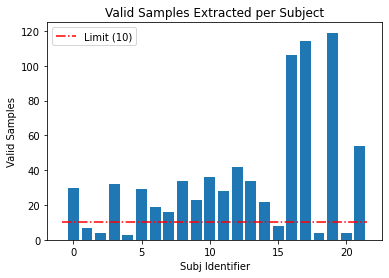

In [370]:
lim = 10
counts = [len(valid_windows_by_user[i]) for i in range(NUM_SUBJ)]
fig,ax = plt.subplots()
ax.bar(range(NUM_SUBJ), counts)
ax.plot([-0.8, 21.5], [lim, lim], 'r-.')
ax.set_xlabel('Subj Identifier')
ax.set_ylabel('Valid Samples')
ax.set_title('Valid Samples Extracted per Subject')
ax.legend([f'Limit ({lim})'])
use_subjs = [i for i in range(NUM_SUBJ) if len(valid_windows_by_user[i]) > 8]
print(f'Keeping {len(use_subjs)} subjects {use_subjs}')

In [371]:
## Compute features for each valid window, split into a train & test set

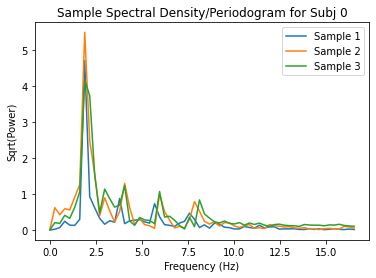

In [372]:
all_rows = []
fig,ax = plt.subplots()
for i_subj in use_subjs:
    for i_win, window in enumerate(valid_windows_by_user[i_subj]):
        avg_magnitude = np.mean(window['mag_acc'])
        avg_dt = np.mean(window['t'].values[1:] - window['t'].values[:-1])
        fs, pxx, top_fs, top_pxx = AccelUtils.compute_periodogram_with_peaks(
            window,
            RESAMPLE_TIME_STEP,
            MAX_RESAMPLE_PTS,
            max_peaks=3)
        
        all_rows.append([avg_magnitude, avg_dt, *top_fs, *top_pxx, i_subj])
        
        if i_subj==0 and i_win < 3:
            ax.plot(fs, pxx)
            
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Sqrt(Power)')
ax.set_title('Sample Spectral Density/Periodogram for Subj 0')
ax.legend(['Sample 1', 'Sample 2', 'Sample 3'])
col_headers = ['avg_mag', 'avg_dt', 'freq_1', 'freq_2', 'freq_3', 'pow_1', 'pow_2', 'pow_3', 'label']

### Some standard data cleaning
Make sure labels are integers, remove any NA values

In [373]:
df = pd.DataFrame.from_records(all_rows, columns=col_headers)
df.dropna(axis=0, inplace=True)
df['label'] = df['label'].astype('int32')
print('Total dataset size:', df.shape)
df.head(4)

Total dataset size: (737, 9)


,avg_mag,avg_dt,freq_1,freq_2,freq_3,pow_1,pow_2,pow_3,label
0,10.047911,0.030403,1.897019,3.794038,5.691057,0.746059,0.138368,0.115573,0
1,9.990958,0.030000,1.897019,4.065041,5.962060,0.706131,0.166182,0.127687,0
2,10.017412,0.030079,1.897019,2.981030,4.065041,0.638005,0.173608,0.188388,0
3,10.241833,0.030000,1.897019,4.065041,5.962060,0.650627,0.175760,0.173613,0


------

## Split the Data into Test and Train Sets
We use sklearn's StratifiedKFold to make sure we get proportional representation of all classes in both test and train sets

In [374]:
# First arg to the split() method doesn't actually matter
skf = StratifiedKFold(n_splits=5)
splits = skf.split([0]*df.shape[0], df['label'].values)
train_indices, test_indices = list(splits)[0]

X_train = df.iloc[train_indices, :8]
y_train = df.iloc[train_indices, 8]
X_test = df.iloc[test_indices, :8]
y_test = df.iloc[test_indices, 8]
print(f'Training shapes: X ~ {X_train.shape}, y ~ {y_train.shape}')
print(f'Testing shapes:  X ~ {X_test.shape}, y ~ {y_test.shape}')


Training shapes: X ~ (589, 8), y ~ (589,)
Testing shapes:  X ~ (148, 8), y ~ (148,)


### Normalize Input Features
We use sklearn's standard scaler 

In [375]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We can pickle the scaler to disk to save for later
import pickle
with open('xdata_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)


In [376]:
# KNN Distance Metric is sensitive to noisy features.  PCA could remove some of that.
_ = '''
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X_train_scaled)
print('Variance of each PCA component:', pca.explained_variance_ratio_)
print(f'Total variance explained: {sum(pca.explained_variance_ratio_):.3f}')
X_train_scaled = pca.transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)
print(X_train_scaled.shape)
'''
# EDIT: This didn't work well


### Create Classifier and Train
"Training" is a funny word to use with KNN -- you just add all the training samples to a list...

In [377]:
# No real need to mess with any options, I'm assuming that L2 distance metric is good enough.
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=1)

In [378]:
y_pred = knn.predict(X_test_scaled)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           3       0.50      0.43      0.46         7
           5       0.33      0.17      0.22         6
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.20      0.17      0.18         6
           9       0.33      0.60      0.43         5
          10       0.00      0.00      0.00         7
          11       0.40      0.33      0.36         6
          12       0.50      0.62      0.56         8
          13       0.17      0.14      0.15         7
          14       0.33      0.25      0.29         4
          16       0.58      0.82      0.68        22
          17       0.48      0.64      0.55        22
          19       0.60      0.50      0.55        24
          21       0.27      0.27      0.27        11

    accuracy                           0.45       148
   macro avg       0.36   

Considering there are 18 different subjects...
* Getting about **45%** accuracy is probably pretty good
* The only people for whom we have zero precision/recall are those with very few samples

Confusion Matrix


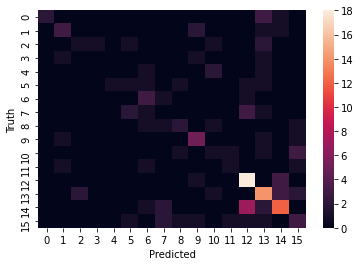

In [379]:
fig,ax = plt.subplots()
ax = sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_pred, labels=use_subjs), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
print('Confusion Matrix')

fig.savefig('confusion_matrix.png')

Confusion Matrix isn't all that exciting...